In [11]:
import datetime
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.api import VAR 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder,  MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout, Flatten, BatchNormalization
import tensorflow_probability as tfp
from tensorflow_probability.python.distributions import Normal
tfb = tfp.bijectors
tfd = tfp.distributions

In [12]:
os.chdir('C:\\Users\\loren\\OneDrive - Università degli Studi di Milano\\Lezioni uni\\Tesi\\Dataset Energia\\')
path = 'Italy'

In [13]:
def retrieve_data(path):

    columns = ['Biomass  - Actual Aggregated [MW]',
       'Fossil Coal-derived gas  - Actual Aggregated [MW]',
       'Fossil Gas  - Actual Aggregated [MW]',
       'Fossil Hard coal  - Actual Aggregated [MW]',
       'Fossil Oil  - Actual Aggregated [MW]',
       'Geothermal  - Actual Aggregated [MW]',
       'Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]',
       'Other  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]',
       'Waste  - Actual Aggregated [MW]',
       'Wind Onshore  - Actual Aggregated [MW]', 'Time']

    # creo il vettore degli anni e il df vuoto dove appendere i singoli df
    years = [2016, 2017, 2018, 2019, 2020, 2021] # , 2022
    tot = pd.DataFrame()
    
    # carico i dati dei diversi anni
    for year in years:
        df = pd.read_csv(os.path.join(path, f"ITA{year}.csv"), parse_dates = ['MTU'])
        #df = df.reset_index()
        
        # aggiusto il formato della data in YYYY-MM-DD HH:mm:ss
        for i, row in df.iterrows():
            df["MTU"][i] = df['MTU'][i][:16]
        
        #df = df.drop_duplicates()
        
        df['Time'] = pd.to_datetime(df['MTU'], utc=True, infer_datetime_format=True)

        df.Time = df.Time.dt.strftime('%Y-%m-%d %H:%M:%S')

        df['Time'] = df['Time'].drop_duplicates()

        df = df[columns].sort_values(by=['Time'])
        
        # appendo i vari df a quello vuoto principale
        tot = pd.concat([tot, df], ignore_index=True)
    
    # imposto la data come indice
    tot = tot.set_index(pd.DatetimeIndex(tot['Time']))

    #tot.sort_index
    
    return tot
data = retrieve_data(path)

C:\Users\loren\AppData\Local\Temp\ipykernel_32652\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_32652\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16]
C:\Users\loren\AppData\Local\Temp\ipykernel_32652\2830682557.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["MTU"][i] = df['MTU'][i][:16

In [14]:
print('There are {} missing values or NaNs in df_final.'.format(data.isnull().values.sum()))

data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

There are 2245 missing values or NaNs in df_final.


In [15]:
def data_and_aggregator(df):

    # seleziono tutte le colonne delle fonti energetiche
    columns = df.columns[ : df.shape[1]-1]

    # aggrego giornalmente i dati
    #daily_df = pd.DataFrame(df[columns].groupby([pd.Grouper(level='Time', freq='D')]).sum())

    # creo l'aggregato totale
    df['total_aggregated'] = df[columns].sum(axis=1)

    # aggrego i dati dell'idroelettrico
    hydro_cols = ['Hydro Pumped Storage  - Actual Aggregated [MW]',
       'Hydro Run-of-river and poundage  - Actual Aggregated [MW]',
       'Hydro Water Reservoir  - Actual Aggregated [MW]']
    
    df['hydro_tot'] = df[hydro_cols].sum(axis=1)

    # aggrego i dati del gas
    gas_cols = ['Fossil Coal-derived gas  - Actual Aggregated [MW]',
                'Fossil Gas  - Actual Aggregated [MW]']
    
    df['gas_tot'] = df[gas_cols].sum(axis=1)

    df = df.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'hard_coal', 
                            'Fossil Oil  - Actual Aggregated [MW]': 'oil',
                            'Geothermal  - Actual Aggregated [MW]': 'geothermal',
                            'Waste  - Actual Aggregated [MW]': 'waste',
                            'Other  - Actual Aggregated [MW]': 'other',
                            'Solar  - Actual Aggregated [MW]' : 'solar',
                            'Wind Onshore  - Actual Aggregated [MW]' : 'wind',
                            'Biomass  - Actual Aggregated [MW]' : 'biomass'})
    
    df = df.drop(df[hydro_cols], axis = 1)
    df = df.drop(df[gas_cols], axis = 1)

    return df
data = data_and_aggregator(data)

In [16]:
# creo due dunzioni: una per i weekend (quando sabato/domenica è 1, altrimenti 0) e l'altra per le vacanze (1/1, 25/4, 1/5, 2/6, 15/8, 25/12)
def businesshour_and_we_generation(df):
    # Generate 'weekend' feature
    for i in range(len(df)):
        position = df.index[i]
        hour = position.hour
        weekend = position.weekday()
        df.loc[position, 'weekend'] = weekend
        df.loc[position, 'hour'] = hour
        
        if (weekend == 5):
            df.loc[position, 'saturday'] = 1
            df.loc[position, 'weekend'] = 1
        elif (weekend == 6):
            df.loc[position, 'sunday'] = 1
            df.loc[position, 'weekend'] = 2
        else:
            df.loc[position, 'saturday'] = 0
            df.loc[position, 'sunday'] = 0
            df.loc[position, 'weekend'] = 0
            
        if (hour >= 8 and hour <= 18):
            df.loc[position, 'business hour'] = 1
        else:
            df.loc[position, 'business hour'] = 0

    df.saturday = df.saturday.fillna(0)
    df.sunday = df.sunday.fillna(0)

    return df

data = businesshour_and_we_generation(data)

In [17]:
data = data.dropna()

# LSTM

## Defining the models

In [18]:
def create_sliding_window(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [19]:
def plot_model_rmse_and_loss(history):
    
    #evaluating train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #visualizing epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    #plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    #plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')

    plt.show()

def plot_preds_vs_actual(true, preds):
    plt.figure(figsize=(12,6))
    plt.plot(true, label='Real')
    plt.plot(preds, label='Predicted', color = 'red')
    plt.title('Predicted vs Real Values')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Total Aggregated')
    plt.legend()
    plt.show()

In [10]:
# (1)
#def create_sliding_window(data, window_size):
#    X = []
#    y = []
#    for i in range(len(data)-window_size-1):
#        X.append(data[i:i+window_size])
#        y.append(data[i+window_size])
#    return np.array(X), np.array(y)

In [20]:
#train_split = 0.7
n_train = 35064
n_test = int(len(data)-n_train)
#sequence_length = 24

features = ['total_aggregated']
n_features = len(features)
feature_array = data[features].values

# (2)
# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = target_scaler.transform(feature_array)


X_train, y_train = create_sliding_window(scaled_array[:n_train], 1)
X_test, y_test = create_sliding_window(scaled_array[n_train:], 1)


In [21]:
truth = feature_array[-len(y_test):]

In [22]:
input_shape1 = X_train.shape[-2:]

loss = tf.keras.losses.MeanSquaredError()

metric = [tf.keras.metrics.RootMeanSquaredError()]

#lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 10))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.003)

In [23]:
tf.keras.backend.clear_session()

#model building

lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=input_shape1),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm.summary()

lstm.compile(loss=loss, optimizer=optimizer, metrics=metric)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1)              12        
                                                                 
 dropout (Dropout)           (None, 1, 1)              0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 1)              12        
                                                                 
 dropout_1 (Dropout)         (None, 1, 1)              0         
                                                                 
 flatten (Flatten)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable para

In [24]:
n_forecast_steps = 24  # This could be 1 if you want to predict one step at a time
window = 24*365*3

In [ ]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions = [] # LISTA DELLE PREVISIONI
errors = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    lstm.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = lstm.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = target_scaler.inverse_transform(yhat)

    #rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    #errors.append(rmse)
    predictions.extend(yhat_rescaled)

    #print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

In [26]:
#y_true = pd.Series(feature_array[-len(predictions):].flatten())
res=pd.DataFrame()
res['y_true'] = pd.Series(truth.flatten())
res['y_pred'] = predictions

rmse = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Mean Squared Error:', rmse)

Mean Squared Error: 3181.0174472957547


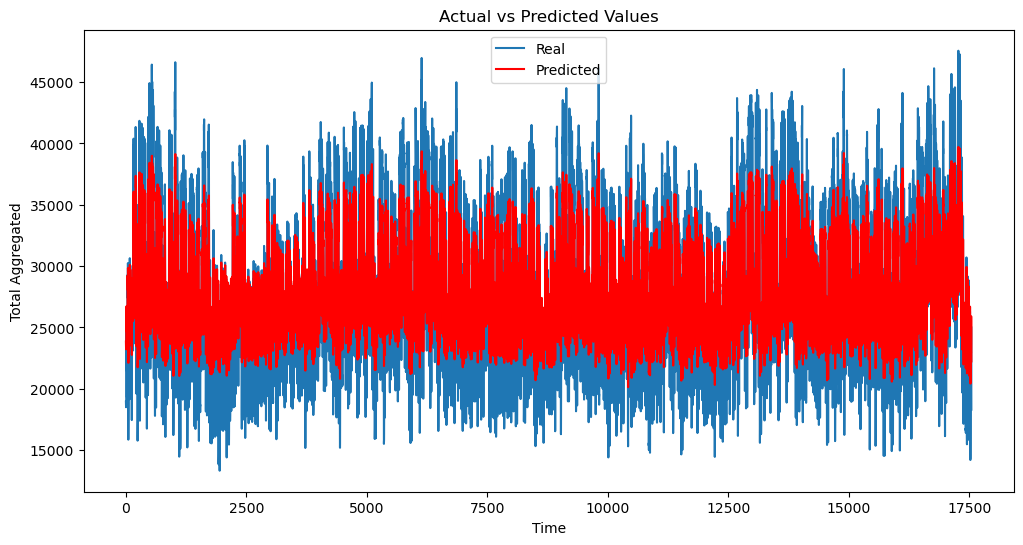

In [27]:
plot_preds_vs_actual(truth, predictions)

In [63]:
#scaled_predictions = target_scaler.transform(predictions)
#scaled_truth = target_scaler.transform(truth)
#
#scaled_mse = sqrt(np.mean((scaled_predictions - scaled_truth)**2))
#print('Mean Squared Error:', scaled_mse)

## Forecast with dummy variables for saturday and sunday

In [58]:
#train_split = 0.7
n_train = 35064
n_test = int(len(data)-n_train)

features = ['total_aggregated']
sat = ['saturday']
sun = ['sunday']

feature_array = data[features].values
#dummy = data[we].values
dummy_1 = data[sat].values
dummy_2 = data[sun].values
dummies = [dummy_1, dummy_2]

## concatenate dummy variables with feature_array
#feature_array = np.concatenate((feature_array, dummy_array), axis=1)


In [59]:
# Fit Scaler only on Training target values
target_scaler = StandardScaler()

# Transfom on both Training and Test data
target_scaler.fit(feature_array[:n_train].reshape(-1,1))
scaled_array = target_scaler.transform(feature_array)

In [60]:
# concatenate dummy variables with feature_array
final_array = np.concatenate((scaled_array, dummy_1), axis=1)
final_array = np.concatenate((final_array, dummy_2), axis=1)

In [61]:
sequence_length = 1
#n_features = 3
X, y = create_sliding_window(final_array, 1)

In [62]:
# Then, split into train and test
X_train = X[:n_train]
y_train = y[:n_train, 0]  # Select only the first column (the scaled feature values)

X_test = X[n_train:]
y_test = y[n_train:, 0]  # Select only the first column (the scaled feature values)

In [63]:
input_shape2 = X_train.shape[-2:]

In [64]:
tf.keras.backend.clear_session()

#model building

lstm2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=input_shape2),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm2.summary()

lstm2.compile(loss=loss, optimizer=optimizer, metrics=metric)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 2)              48        
                                                                 
 dropout (Dropout)           (None, 1, 2)              0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 2)              40        
                                                                 
 dropout_1 (Dropout)         (None, 1, 2)              0         
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable para

In [ ]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions2 = [] # LISTA DELLE PREVISIONI
errors2 = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    lstm2.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = lstm2.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = target_scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors.append(rmse)
    predictions2.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

In [66]:
#truth2 = pd.Series(feature_array[-len(predictions2):].flatten())
#res2=pd.DataFrame()
#res2['y_true'] = truth2
res['y_pred2'] = predictions2

In [67]:
rmse2 = sqrt(np.mean((res.y_true - res.y_pred2)**2))
print('Mean Squared Error:', rmse2)

Mean Squared Error: 2678.873830548949


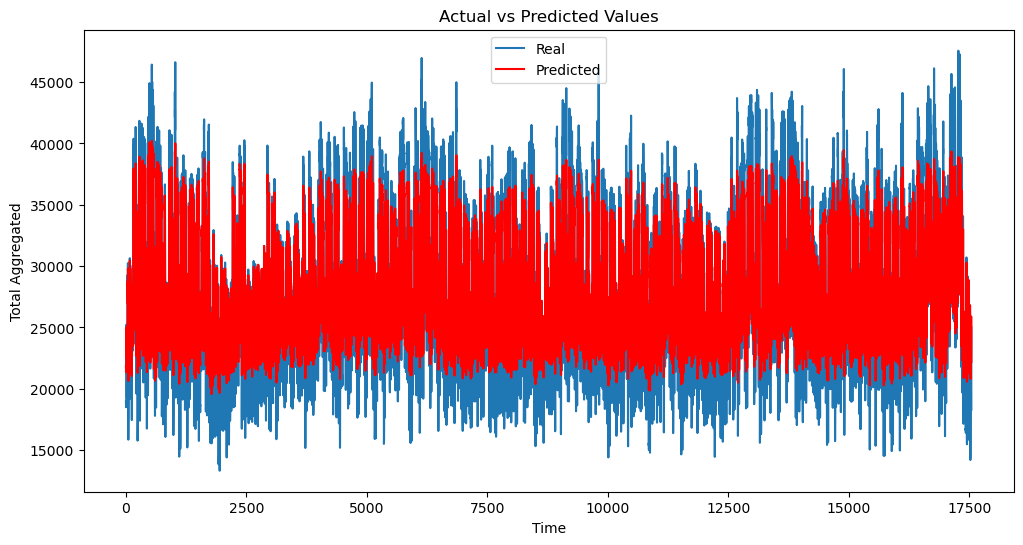

In [68]:
plot_preds_vs_actual(res.y_true, res.y_pred2)

# Forecast with business hour dummy

In [73]:
# il 2020 inizia a inidce 35068

features = ['total_aggregated']
dummy_features = ['business hour']

feature_array = data[features].values
dummy_array = data[dummy_features].values

## concatenate dummy variables with feature_array
#feature_array = np.concatenate((feature_array, dummy_array), axis=1)

# Fit Scaler only on Training target values
target_scaler = StandardScaler()
target_scaler.fit(feature_array[:n_train].reshape(-1,1))

# Transfom on both Training and Test data
scaled_array = target_scaler.transform(feature_array)

# concatenate dummy variables with feature_array
final_array = np.concatenate((scaled_array, dummy_array), axis=1)

#sequence_length = 2
#X_train, y_train = create_sliding_window(final_array[:n_train], sequence_length)
#X_test, y_test = create_sliding_window(final_array[n_train:], sequence_length)


In [74]:
#sequence_length = 24
#n_features = 3
X, y = create_sliding_window(final_array, 1)
# Then, split into train and test
X_train = X[:n_train]
y_train = y[:n_train, 0]  # Select only the first column (the scaled feature values)

X_test = X[n_train:]
y_test = y[n_train:, 0]  # Select only the first column (the scaled feature values)

In [75]:
input_shape3 = X_train.shape[-2:]

tf.keras.backend.clear_session()

In [76]:
#model building

lstm3 = tf.keras.Sequential([
    tf.keras.layers.LSTM(10, return_sequences=True, input_shape=input_shape3),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1, activation='relu'),
    tf.keras.layers.Dense(1),
])

lstm3.summary()


lstm3.compile(loss=loss, optimizer=optimizer, metrics=metric)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 2)              40        
                                                                 
 dropout (Dropout)           (None, 1, 2)              0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 2)              40        
                                                                 
 dropout_1 (Dropout)         (None, 1, 2)              0         
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 83
Trainable params: 83
Non-trainable para

In [ ]:
history_X = X_train.copy() # LA DIMENSIONE DEL TRAIN è DI 24*365*3 ORE -> 3 ANNI
history_y = y_train.copy()

predictions3 = [] # LISTA DELLE PREVISIONI
errors3 = [] # LISTA DEI RMSE PER GIORNO
days = 1 # COUNTER DEI GIORNI
for i in range(0, len(X_test), n_forecast_steps):
    t_end = i + n_forecast_steps # A PARTIRE DALLA POSIZIONE i DEL TEST SET INDICO FINO A QUALE POSIZONE SI FANNO LE PREVISIONI, OVVERO OGNI 24 ORE/POSIZIONI.
                                 # E.G.: SE L'INDICE è 0 SI FA FORECASTING FINO ALLA POSIZIONE 24 (0+24), SE L'INDICE è 24 FINO ALLA POSIZIONE 48 ECC
    if t_end > len(X_test):      
        t_end = len(X_test)
    X_test_block = X_test[i:t_end] # PRENDO IL BLOCCO DEL TEST SET SU CUI FARE FORECASTING USANDO LE POSIZIONI DICHIARATE PRIMA
    y_test_block = y_test[i:t_end]
    truth_block = truth[i:t_end]

    print('training and predicting for period', days)
    lstm3.fit(history_X, history_y, epochs=100, verbose=0, batch_size=168, callbacks=[early_stopping]) # FACCIO TRAINING SULLA WINDOW USANDO 100 EPOCHE
                                                                                                         # L'ARGOMENTO "EARLY STOPPING" FA IN MODO CHE IL TRAINING SULLA WINDOW ATTUALE
                                                                                                         # SI STOPPI DOPO SE DOPO X EPOCHE (IN QUESTO CASO HO SETTATO IL PARAMETRO A 10)
                                                                                                         # LA LOSS (RMSE) NON DIMINUISCE 

    yhat = lstm3.predict(X_test_block)                          # FACCIO LE PREVISIONI, LE RI-TRASFORMO NELLA SCALA ORIGINALE (PRIMA ERANO TRASFORMATE CON UNO SCALING PER VELOCIZZARE IL TRAINING)
                                                              # INSIEME AL BLOCCO DEL Y_TEST ATTUALE 
    yhat_rescaled = target_scaler.inverse_transform(yhat)

    rmse = sqrt(np.mean(truth_block - yhat_rescaled)**2)  # CALCOLO RMSE DEL GIORNO, POI APPENDO SIA RMSE CHE PREVISIONI ALLE RISPETTIVE LISTE
    errors.append(rmse)
    predictions3.extend(yhat_rescaled)

    print('Mean Squared Error:', rmse)
    
    days = days + 1
    
    # Update the history with the latest "known" data
    history_X = np.concatenate((history_X, X_test_block), axis=0)
    history_X = history_X[n_forecast_steps:]

    history_y = np.concatenate((history_y, y_test_block), axis=0)
    history_y = history_y[n_forecast_steps:]

In [78]:
#res3=pd.DataFrame()
#res3['y_true'] = res['y_true']
res['y_pred3'] = predictions3
#scaled_predictions = target_scaler.transform(predictions3)
#scaled_truth = target_scaler.transform(truth.reshape(-1,1))
#
rmse3 = sqrt(np.mean((res.y_true - res.y_pred3)**2))
print('Root Mean Squared Error:', rmse3)

Root Mean Squared Error: 2569.142755862352


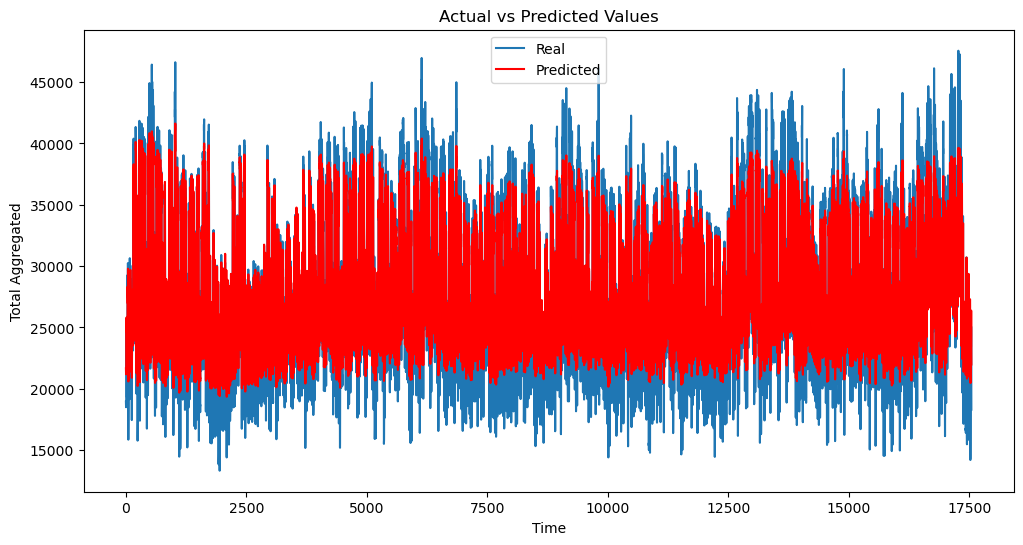

In [79]:
plot_preds_vs_actual(res.y_true, res.y_pred3)


In [85]:
#truth = pd.Series(feature_array[-len(y_test):].flatten())

In [80]:
rmse1 = sqrt(np.mean((res.y_true - res.y_pred)**2))
print('Root Mean Squared Error just TS:', rmse1)
rmse2 = sqrt(np.mean((res.y_true - res.y_pred2)**2))
print('Root Mean Squared Error WE dummies:', rmse2)
rmse3 = sqrt(np.mean((res.y_true - res.y_pred3)**2))
print('Root Mean Squared Error BH dummy:', rmse3)

Root Mean Squared Error just TS: 3181.0174472957547
Root Mean Squared Error WE dummies: 2678.873830548949
Root Mean Squared Error BH dummy: 2569.142755862352
